In [78]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tqdm
from datetime import datetime, date, time
import seaborn as sns

Инициализируем список с названием столбцов, для локальной загрузки базы данных

In [5]:
columns = ['_id',
 'id',
 'name',
 'username',
 'state',
 'avatar_url',
 'web_url',
 'created_at',
 'bio',
 'location',
 'public_email',
 'skype',
 'linkedin',
 'twitter',
 'website_url',
 'organization',
 'last_sign_in_at',
 'confirmed_at',
 'last_activity_on',
 'email',
 'theme_id',
 'color_scheme_id',
 'projects_limit',
 'current_sign_in_at',
 'identities',
 'can_create_group',
 'can_create_project',
 'two_factor_enabled',
 'external',
 'private_profile',
 'is_admin',
 'emails',
 'projects']

Загрузим локально сохраненный датасет.
Данные о цифровом следе студентов в GitLab хранятся в коллекции “git” 

In [6]:
n = 7
df = pd.DataFrame(columns=columns)
for i in range(0,n - 1):
  print(i)
  with open(f'/content/drive/MyDrive/bd_git/git_{i}.json', 'rb') as f:
    df_el = pd.read_json(f, compression='zip')
  df = pd.concat([df, df_el])
with open(f'/content/drive/MyDrive/bd_git/git_{n - 1}.json', 'rb') as f:
    df_el = pd.read_json(f, compression='zip')
df = pd.concat([df, df_el])


0
1
2
3
4
5


Для первоначального анализа метрик проектной эффективности выделим следующие:


*   commitsСount - количество коммитов студента в проекте
*   activeDaysCount - количество дней в году, когда студент делал коммиты
*   activeWeeksCount - количество недель в году, когда студент делал коммиты
*   activeMonthCount - количество месяцев в году, когда студент делал коммиты
*   additionsSum - количество добавленных строк во всех коммитах студента в проекте
*   deletionsSum - количество удаленных строк во всех коммитах студента в проекте




In [53]:
df_features = pd.DataFrame(columns=['name', 'namespaceName', 'commitsСount', 'activeDaysCount', 'activeWeeksCount', 'activeMonthCount', 'additionsSum', 'deletionsSum'])

Для анализа возьмем проекты, в которых студенты работали в 2021-2022 гг

In [8]:
edu_year_start = date(2021, 9, 1)

In [9]:
edu_year_end = date(2022, 6, 25)

In [10]:
from tqdm import tqdm

In [54]:
%%time
#проходимся по каждой строке в датафрейме
for i in tqdm(range(len(df))):
    #проверяем, не является ли признак projects пустым. Если он пустой, то пропускаем эту строку 
    if pd.json_normalize(df.iloc[i]['projects']).shape[0] == 0 or pd.json_normalize(df.iloc[i]['projects']).shape[
        1] == 0:
        continue
    #если он оказался не пустым, то записываем имя студента, а так же все его проекты: нам важные только колонки 'namespace.name' и 'commits'
    name = df.iloc[i]['name']
    person_projects = pd.json_normalize(df.iloc[i]['projects'])[['namespace.name', 'commits']]
    #избавляемся от NaN, если они есть
    person_projects = person_projects[~person_projects['namespace.name'].isnull()]
    #применяем фильтр проектов, чтобы взять только учебные
    person_projects = person_projects[person_projects['namespace.name'].apply(
        lambda x: x[0].isdigit()
                  and x[-1].isalpha())]
    #проходимся по каждому учебному проекту студента
    for i in range(person_projects.shape[0]):
        #ненулевой DaеaFrame с коммитами
        commits_df = pd.json_normalize(person_projects.iloc[i]['commits'])
        if commits_df.shape[0] == 0:
            continue
        #преобразуем committed_date к datetime
        commits_df['committed_date'] = pd.to_datetime(commits_df['committed_date'], unit='ms')
        namespace_name = person_projects.iloc[i]['namespace.name']
        #берем только те коммиты, которые были сделаны в 2021-2022 гг
        commits_df = commits_df[commits_df['committed_date'].apply(
            lambda date: date.date() > edu_year_start and date.date() < edu_year_end)]
        commits_count = commits_df.shape[0]
        #создаем множества активных дней, недель и месяцев и считаем их длины
        active_days_count = len(set(commits_df['committed_date'].map(lambda x: 10000 * x.year + 100 * x.month + x.day)))
        active_weeks_count = len(
            set(commits_df['committed_date'].map(lambda x: 10000 * x.year + 100 * x.month + x.week)))
        active_month_count = len(set(commits_df['committed_date'].map(lambda x: 100 * x.year + x.month)))
        additions_sum = commits_df['stats.additions'].sum()
        deletions_sum = commits_df['stats.deletions'].sum()
        #если в данном проекте в 2021-2022 гг студентом была сделана хоть какая-то работа, записываем результат в DataFrame
        if (
                commits_count + active_days_count + active_weeks_count + active_month_count + additions_sum + deletions_sum) != 0:
            df_features = df_features.append({'name': name,
                                              'namespaceName': namespace_name,
                                              'commitsСount': commits_count,
                                              'activeDaysCount': active_days_count,
                                              'activeWeeksCount': active_weeks_count,
                                              'activeMonthCount': active_month_count,
                                              'additionsSum': additions_sum,
                                              'deletionsSum': deletions_sum}, ignore_index=True)


100%|██████████| 3233/3233 [01:11<00:00, 45.11it/s] 

CPU times: user 1min 8s, sys: 563 ms, total: 1min 8s
Wall time: 1min 11s


Приводим столбцы к типу int

In [55]:
df_features = df_features.astype({'commitsСount': 'int32',
                    'activeDaysCount': 'int32',
                    'activeWeeksCount': 'int32',
                    'activeMonthCount': 'int32',
                    'additionsSum': 'int32',
                    'deletionsSum': 'int32'})

In [17]:
df_features[['namespaceName',	'commitsСount',	'activeDaysCount',	'activeWeeksCount',	'activeMonthCount',	'additionsSum',	'deletionsSum']].head(20)

,namespaceName,commitsСount,activeDaysCount,activeWeeksCount,activeMonthCount,additionsSum,deletionsSum
0,1037 Создание пользовательского интерфейса для...,2,2,2,1,10,4
1,806 Клиентская часть системы управления микрок...,32,11,8,6,5329,383
2,511 Разработка программной части системы управ...,3,2,2,2,207,3
3,19102 Телецентр МИЭМ,15,7,5,3,165,136
4,19102 Телецентр МИЭМ,1,1,1,1,0,6
5,246 Телевидение МИЭМ,1,1,1,1,353,16
6,246 Телевидение МИЭМ,10,2,2,1,789,657
7,19107 Студия самозаписи,27,7,2,2,51113,12237
8,19107 Студия самозаписи,4,2,2,2,1226,31
9,19107 Студия самозаписи,1,1,1,1,3,2


Заметим, из-за того, что названия учебных проектов это названия проектов гитлаба, а не репрозиториев, поэтому одному проекту могут соответствовать несколько репрозиториев, что нам не подходит. Немного перепишем код, но теперь при повторе имени студента и названии namespace, мы будем обновлять уже имеющуюся строку, а не добавлять новую

In [70]:

df_features = pd.DataFrame(columns=['name', 'namespaceName', 'commitsСount', 'activeDaysCount', 'activeWeeksCount', 'activeMonthCount', 'additionsSum', 'deletionsSum'])

In [71]:
% % time
for i in tqdm(range(len(df))):
    if pd.json_normalize(df.iloc[i]['projects']).shape[0] == 0 or pd.json_normalize(df.iloc[i]['projects']).shape[
        1] == 0:
        continue
    name = df.iloc[i]['name']
    person_projects = pd.json_normalize(df.iloc[i]['projects'])[['namespace.name', 'commits']]
    person_projects = person_projects[~person_projects['namespace.name'].isnull()]
    person_projects = person_projects[person_projects['namespace.name'].apply(
        lambda x: x[0].isdigit()
                  and x[-1].isalpha())]

    for i in range(person_projects.shape[0]):
        commits_df = pd.json_normalize(person_projects.iloc[i]['commits'])
        if commits_df.shape[0] == 0:
            continue
        commits_df['committed_date'] = pd.to_datetime(commits_df['committed_date'], unit='ms')
        namespace_name = person_projects.iloc[i]['namespace.name']
        commits_df = commits_df[commits_df['committed_date'].apply(
            lambda date: date.date() > edu_year_start and date.date() < edu_year_end)]
        commits_count = commits_df.shape[0]
        # добавление в ячейку датафрейма множества, а не сразу длины, для дальнейшего его расширения
        active_days_count = set(commits_df['committed_date'].map(lambda x: 10000 * x.year + 100 * x.month + x.day))
        active_weeks_count = set(commits_df['committed_date'].map(lambda x: 10000 * x.year + 100 * x.month + x.week))
        active_month_count = set(commits_df['committed_date'].map(lambda x: 100 * x.year + x.month))
        additions_sum = commits_df['stats.additions'].sum()
        deletions_sum = commits_df['stats.deletions'].sum()

        persons_namespace = df_features[df_features['name'] == name]['namespaceName']

        if (commits_count + len(active_days_count) + len(active_weeks_count) + len(
                active_month_count) + additions_sum + deletions_sum != 0) and (
                namespace_name not in persons_namespace.unique()):
            df_features = df_features.append({'name': name,
                                              'namespaceName': namespace_name,
                                              'commitsСount': commits_count,
                                              'activeDaysCount': active_days_count,
                                              'activeWeeksCount': active_weeks_count,
                                              'activeMonthCount': active_month_count,
                                              'additionsSum': additions_sum,
                                              'deletionsSum': deletions_sum}, ignore_index=True)
        elif (commits_count + len(active_days_count) + len(active_weeks_count) + len(
                active_month_count) + additions_sum + deletions_sum != 0) and (
                namespace_name in persons_namespace.unique()):
            # если уже встречалось - дополняем, а не добавляем новый, а для множеств ищем объединения
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'commitsСount'] += commits_count
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'activeDaysCount'] |= active_days_count
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'activeWeeksCount'] |= active_weeks_count
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'activeMonthCount'] |= active_month_count
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'additionsSum'] += additions_sum
            df_features.loc[
                df_features[(df_features['name'] == name) & (df_features['namespaceName'] == namespace_name)].index[
                    0], 'deletionsSum'] += deletions_sum


100%|██████████| 3233/3233 [01:11<00:00, 45.41it/s] 

CPU times: user 1min 9s, sys: 691 ms, total: 1min 9s
Wall time: 1min 11s


In [72]:
df_features[['namespaceName',	'commitsСount',	'activeDaysCount',	'activeWeeksCount',	'activeMonthCount',	'additionsSum',	'deletionsSum']].head(20)

,namespaceName,commitsСount,activeDaysCount,activeWeeksCount,activeMonthCount,additionsSum,deletionsSum
0,1037 Создание пользовательского интерфейса для...,2,"{20211124, 20211117}","{20211146, 20211147}",{202111},10,4
1,806 Клиентская часть системы управления микрок...,32,"{20220507, 20220103, 20211208, 20211209, 20211...","{20220101, 20220518, 20220104, 20211147, 20220...","{202112, 202201, 202204, 202205, 202206, 202111}",5329,383
2,511 Разработка программной части системы управ...,3,"{20210930, 20211002}","{20210939, 20211039}","{202109, 202110}",207,3
3,19102 Телецентр МИЭМ,48,"{20211111, 20211112, 20211113, 20211018, 20211...","{20211041, 20211042, 20211043, 20211145, 20211...","{202112, 202109, 202110, 202111}",814,2607
4,246 Телевидение МИЭМ,22,"{20211008, 20210913, 20210909}","{20211040, 20210936, 20210937}","{202109, 202110}",2284,1346
5,19107 Студия самозаписи,86,"{20220418, 20220425, 20220426, 20220427, 20220...","{20220416, 20220417, 20211043, 20220520, 20220...","{202112, 202201, 202202, 202203, 202204, 20220...",106435,13361
6,934 Система учета и мониторинга демографически...,5,"{20211202, 20220419, 20211029}","{20220416, 20211248, 20211043}","{202112, 202204, 202110}",5052,91
7,19112 Сервисы интегрированной цифровой среды,364,"{20220416, 20220418, 20220420, 20211206, 20211...","{20220416, 20220417, 20220310, 20220311, 20220...","{202112, 202110, 202109, 202201, 202202, 20220...",184095,79453
8,447 МИЭМ Quality assurance Автоматизация кон...,88,"{20220608, 20220531, 20220601, 20220602, 20220...","{20220522, 20220622, 20220623}","{202205, 202206}",1519,644
9,448 Система автоматизации рейтингов ВУЗов,15,"{20211124, 20210903, 20211117}","{20210935, 20211146, 20211147}","{202109, 202111}",116,93


Посчитаем длины множеств

In [ ]:
df_features['activeDaysCount'] = df_features['activeDaysCount'].apply(lambda x: len(x))
df_features['activeWeeksCount'] = df_features['activeWeeksCount'].apply(lambda x: len(x))
df_features['activeMonthCount'] = df_features['activeMonthCount'].apply(lambda x: len(x))

In [81]:
df_features = df_features.astype({'commitsСount': 'int32',
                    'activeDaysCount': 'int32',
                    'activeWeeksCount': 'int32',
                    'activeMonthCount': 'int32',
                    'additionsSum': 'int32',
                    'deletionsSum': 'int32'})

In [82]:
df_features[['namespaceName',	'commitsСount',	'activeDaysCount',	'activeWeeksCount',	'activeMonthCount',	'additionsSum',	'deletionsSum']].head(20)

,namespaceName,commitsСount,activeDaysCount,activeWeeksCount,activeMonthCount,additionsSum,deletionsSum
0,1037 Создание пользовательского интерфейса для...,2,2,2,1,10,4
1,806 Клиентская часть системы управления микрок...,32,11,8,6,5329,383
2,511 Разработка программной части системы управ...,3,2,2,2,207,3
3,19102 Телецентр МИЭМ,48,10,7,4,814,2607
4,246 Телевидение МИЭМ,22,3,3,2,2284,1346
5,19107 Студия самозаписи,86,26,12,8,106435,13361
6,934 Система учета и мониторинга демографически...,5,3,3,3,5052,91
7,19112 Сервисы интегрированной цифровой среды,364,78,31,10,184095,79453
8,447 МИЭМ Quality assurance Автоматизация кон...,88,6,3,2,1519,644
9,448 Система автоматизации рейтингов ВУЗов,15,3,3,2,116,93


Посмотрим на попарные отношения признаков. Заметим, что признаки commitsCount, activeDaysCount, activeWeeksCount, activeMonthCount имеют достаточно высокую корелляцию между собой

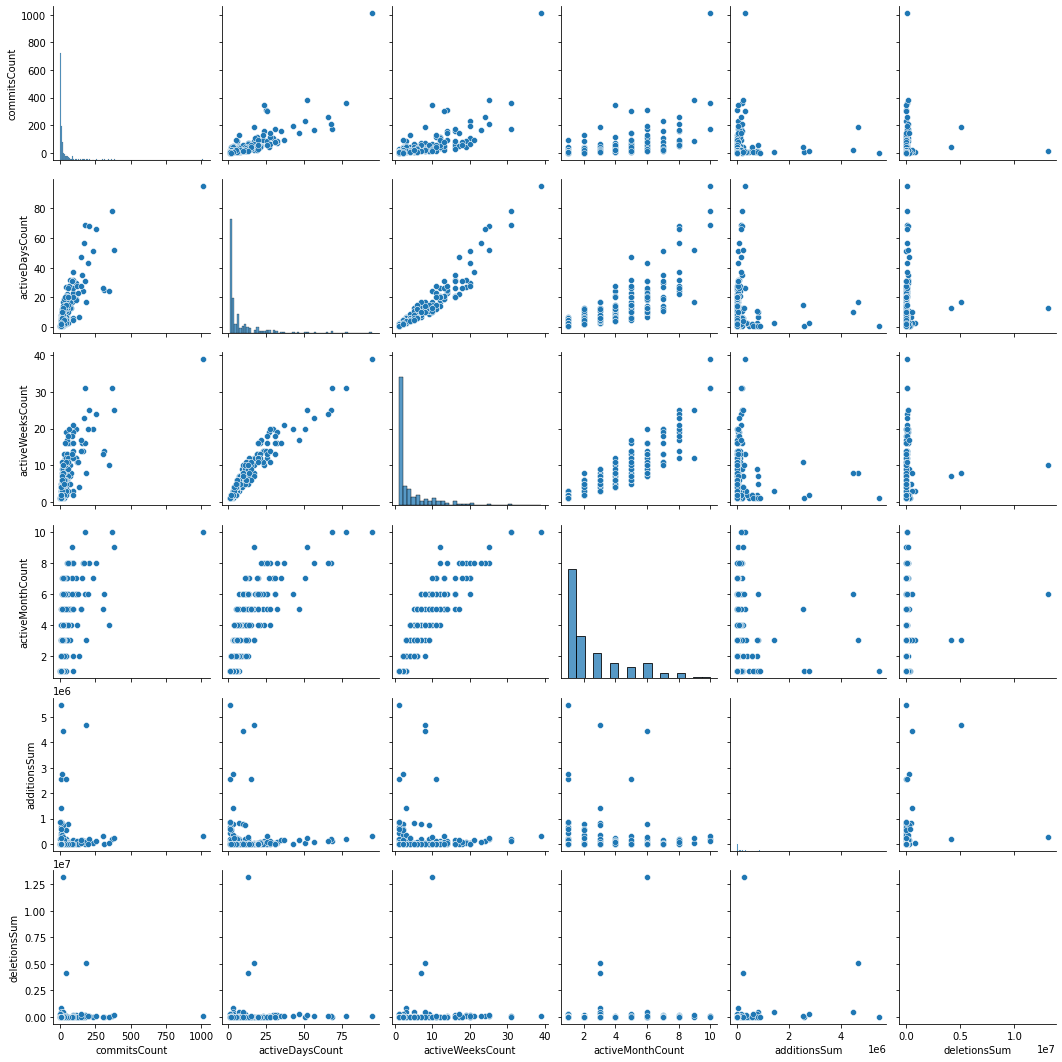

In [79]:
sns.pairplot(df_features)